# Assemble the final Dataframe from tarpmir bindingsites

## Read in data

In [53]:
%load_ext autoreload
%autoreload 2
from helper_fcts import *
path_tarp = 'C:/Users/Lena/Documents/Master big files/TarPmiR_Windows/data/'
path_gdc = 'C:/Users/Lena/Documents/Master big files/GDC_download_legacy/'
path2 = 'C:/Users/Lena/Documents/auf mega gesyncte Dokumente/Uni/Master/Semester 5/Masterarbeit/'
fig_path = 'Dokumente/plots/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
all_mapping, ids = read_in_ids2(path_tarp+'all_mapping_ids.fasta') # mapping gene, transcript, exon ids, all
chrom_exon_starts = read_in_fasta2(path_tarp+'all_exon_start.fasta')
chrom_exon_ends = read_in_fasta2(path_tarp+'all_exon_end.fasta')
exon_starts, exon_ends = calc_exon_data(chrom_exon_starts, chrom_exon_ends)#TODO remove this & instead work with exon_info? slower :(
binding_sites, bs_starts, bs_ends = parse_tarp_bs(path_tarp+'new_input/input_miRNA.fasta_exampleA1BG_mRNA.txt.bp')
exon_info = pd.read_feather(path2+'exon_level_info.feather', use_threads=True)
exon_info = exon_info.rename(columns={'exon_chrom_start': 'chrom_exon_start','exon_chrom_end':'chrom_exon_end'})
exon_info[['chrom_exon_start','chrom_exon_end']] = exon_info[['chrom_exon_start','chrom_exon_end']].apply(pd.to_numeric,downcast='unsigned')
exon_info[['ensembl_gene_id','ensembl_transcript_id','ensembl_exon_id','chromosome_name','strand']] = exon_info[['ensembl_gene_id','ensembl_transcript_id','ensembl_exon_id','chromosome_name','strand']].astype('str').astype('category')

#TODO here
#several dataframes
#0) df_main: bs_id - chr_start - chr_end - miRNA_name - bs_seed - bs_len - tarp_output - transcript_id
#1) df_exon: bs_id - exon_id (cause N-N)
#2) df_gene: strand - chrom - gene_id - gene_name - transcript_id (1-N)

In [251]:
#skip, takes too long, > 10min -> use dicts instead 
def calc_exon_start(exon_info):
    starts = np.zeros(len(exon_info),dtype=int)
    ends = np.zeros(len(exon_info),dtype=int)
    for tid in exon_info.ensembl_transcript_id.unique():
        tids = exon_info[exon_info.ensembl_transcript_id == tid].sort_values(by='exon_chrom_start')
        last_exon_end = 0
        for i in range(len(tids)):
            row = tids[i:i+1]
            this_pos = tids.index.get_loc(row.index[0]) #get position of exon within transcript
            ov_pos = exon_info.index.get_loc(row.index[0])
            if this_pos == 0:
                starts[ov_pos] = 0
                end = (row.exon_chrom_end - row.exon_chrom_start).values[0]
                ends[ov_pos] = end
                last_exon_end = end
            else:
                start = last_exon_end + 1  #get end of exon before
                starts[ov_pos] = start
                end = start + (row.exon_chrom_end - row.exon_chrom_start).values[0]
                last_exon_end = end
                ends[ov_pos] = end
    return starts, ends

#exon_info['exon_start'], exon_info['exon_end'] = calc_exon_start(exon_info)
#exon_info


KeyboardInterrupt: 

## Parse seed & translate genome positions

In [4]:
df_main = binding_sites.copy()
miRNA_sequences = parse_seq(path_tarp+'new_input/input_miRNA.fasta')
df_main['miRNA_seed'] = df_main.apply(lambda row: miRNA_sequences[row['miRNA']], axis=1)
mRNA_sequences = parse_seq(path_tarp+'new_input/exampleA1BG_mRNA.txt')
df_main['mRNA_bs_seq'] = df_main.apply(lambda row: mRNA_sequences[row['mRNA']][row['bs_start']:row['bs_end']], axis=1)

In [5]:
def pos_to_chrom(pos, tid, ids, exon_starts, exon_ends, chrom_exon_starts):
    for j, eid in enumerate(ids[tid]):
        if tid not in exon_starts: print(tid,'not in exon_starts')
        if tid in exon_starts and eid in exon_starts[tid] and tid in exon_ends and eid in exon_ends[tid]:
            if pos >= exon_starts[tid][eid] and pos <= exon_ends[tid][eid]:
                diff = pos - exon_starts[tid][eid]
                chrom_pos = chrom_exon_starts[tid][eid] + diff
                return chrom_pos
        else:
            print(eid,'not in exon_starts')
            return None
df_main['chrom_bs_start'] = df_main.apply(lambda row: pos_to_chrom(row.bs_start, row.mRNA, ids, exon_starts, exon_ends, chrom_exon_starts), axis=1)
df_main['chrom_bs_end'] = df_main.apply(lambda row: pos_to_chrom(row.bs_end, row.mRNA, ids, exon_starts, exon_ends, chrom_exon_starts), axis=1)
df_main['bs_id'] = df_main.index
df_main.head()

,miRNA,mRNA,binding_probability,energy,seed,accessibility,AU_content,PhyloP_Stem,PyloP_Flanking,m/e,...,position_of_longest_consecutive_pairings,pairings_in_3prime_end,difference_of_pairings_between_seed_and_3prime_end,bs_start,bs_end,miRNA_seed,mRNA_bs_seq,chrom_bs_start,chrom_bs_end,bs_id
0,hsa-let-7a-5p,ENST00000600966,0.692308,-15.4,0,0.003371,0.368,-0.568203,0.198163,-7.757047,...,10,6,1,396,416,TGAGGTAGTAGGTTGTATAGTT,AACTACAGCTGCAGCTACCG,58352138,58352158,0
1,hsa-let-7a-2-3p,ENST00000600966,0.923077,-23.2,1,0.000094,0.426,0.844482,-0.095065,-5.585164,...,1,6,1,52,75,CTGTACAGCCTCCTAGCTTTCC,GGGTGGCCCAGGAGCCTGTGCAC,58350645,58351407,1
2,hsa-let-7b-5p,ENST00000600966,0.692308,-21.3,0,0.000009,0.353,1.253080,0.015255,-8.613887,...,1,7,2,775,794,TGAGGTAGTAGGTTGTGTGGTT,ACTACACCTGCCGCTACCG,58352987,58353006,2
3,hsa-let-7b-5p,ENST00000600966,0.692308,-18.5,0,0.000001,0.294,1.302461,-0.092658,-9.582385,...,1,6,1,126,143,TGAGGTAGTAGGTTGTGTGGTT,GGCCGCTACCGCTGCCG,58351458,58351475,3
4,hsa-let-7b-5p,ENST00000600966,0.846154,-19.2,0,0.000174,0.397,0.062334,0.643183,-8.600034,...,12,8,3,560,580,TGAGGTAGTAGGTTGTGTGGTT,GGCTGCACCACCACCGCCTG,58352400,58352420,4


## Parse from mapping

In [258]:
#df_exon = mapping bs_id - exon_id
def get_exon_ids(transcript_id, chrom_bs_start, chrom_bs_end, chrom_exon_starts, chrom_exon_ends):
    exon_ids = []
    for eid in chrom_exon_starts[transcript_id]:
        chrom_exon_start = chrom_exon_starts[transcript_id][eid]
        chrom_exon_end = chrom_exon_ends[transcript_id][eid]
        #TODO strand beachten? look at results? do they make sense?
        if not((chrom_bs_start <= chrom_exon_start and chrom_bs_end <= chrom_exon_start) or (chrom_bs_start >= chrom_exon_end and chrom_bs_end >= chrom_exon_end)):
            exon_ids.append(eid)
    return exon_ids

df_exon = df_main[['mRNA','bs_id','chrom_bs_start','chrom_bs_end']].copy()
df_exon['exon_id'] = df_exon.apply(lambda row: get_exon_ids(row.mRNA, row.chrom_bs_start, row.chrom_bs_end, chrom_exon_starts, chrom_exon_ends), axis=1)
df_exon = df_exon.explode('exon_id')
df_exon['exon_id'] = df_exon['exon_id'].astype('category')
df_exon.head()
#df_exon['chrom_exon_start'] = df_exon.apply(lambda row: chrom_exon_starts[row.mRNA][row.exon_id], axis=1)
#df_exon['chrom_exon_end'] = df_exon.apply(lambda row: chrom_exon_ends[row.mRNA][row.exon_id], axis=1)
#df_exon['exon_len'] = df_exon.apply(lambda row: row.exon_chrom_end - row.exon_chrom_start, axis=1)
del df_exon['chrom_bs_start']
del df_exon['chrom_bs_end']
del df_exon['mRNA']
#TODO remove code that we dont need! dont add columns to delete them later!
df_exon

,bs_id,exon_id
0,0,ENSE00003224625
1,1,ENSE00003509215
1,1,ENSE00003142302
2,2,ENSE00003185372
3,3,ENSE00003509215
...,...,...
24709,24709,ENSE00003207101
24710,24710,ENSE00003207101
24711,24711,ENSE00003207101
24712,24712,ENSE00003024001


In [14]:
#df_gene: strand - chrom - gene_id - gene_name - transcript_id (1-N)
df_gene = pd.read_csv(path2+'gene_infos.csv', dtype={'ensembl_gene_id':str,'ensembl_gene_id_version':str,'ensembl_transcript_id':str, 'ensembl_transcript_id_version':str, 'chromosome_name':'category', 'strand':'int8', 'start_position':int, 'end_position':int})
del df_gene['Unnamed: 0']
df_gene.head()

,ensembl_gene_id,ensembl_gene_id_version,ensembl_transcript_id,ensembl_transcript_id_version,chromosome_name,strand,start_position,end_position
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,MT,1,577,647
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,MT,1,648,1601
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,MT,1,1602,1670
3,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,MT,1,1671,3229
4,ENSG00000209082,ENSG00000209082.1,ENST00000386347,ENST00000386347.1,MT,1,3230,3304


In [129]:
df_exon.dtypes

bs_id                  int64
exon_id             category
exon_chrom_start       int64
exon_chrom_end         int64
dtype: object

## get TCGA data from GDC API 

In [87]:
%load_ext Cython

In [86]:
%%cython
cpdef new_split_chrom_column(Py_UNICODE* chrom):
    cdef Py_UNICODE* chromosome_name
    cdef Py_UNICODE* chrom_list[1]
    cdef int strand
    cdef int chrom_exon_start
    cdef int chrom_exon_end
    chrom_list = chrom.split(':')
    chromosome_name = chrom[0][3:]
    strand = 1 if chrom[2] == '+' else -1
    chrom_exon_start = int(chrom[1].split('-')[0])
    chrom_exon_end = int(chrom[1].split('-')[1])
    return chromosome_name,strand,chrom_exon_start,chrom_exon_end
#cython try of implementing, doesn't work in ipython, wrong version? not installed yet?
#slow! 39.2 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each) with cython
# 36.4 ms ± 795 µs per loop (mean ± std. dev. of 7 runs, 10 loops each) normal

UsageError: Cell magic `%%cython` not found.


In [314]:
%%cython
def c_split_chrom_column(chrom):
    chrom_list = chrom.split(':')
    chromosome_name = str(chrom_list[0][3:])
    strand = 1 if chrom_list[2] == '+' else -1
    chrom_exon_start = int(chrom_list[1].split('-')[0])
    chrom_exon_end = int(chrom_list[1].split('-')[1])
    return chromosome_name,strand,chrom_exon_start,chrom_exon_end

In [315]:
#define list_to_df function

def split_chrom_column(chrom):
    chrom = chrom.split(':')
    chromosome_name = str(chrom[0][3:])
    strand = 1 if chrom[2] == '+' else -1
    chrom_exon_start = int(chrom[1].split('-')[0])
    chrom_exon_end = int(chrom[1].split('-')[1])
    return chromosome_name,strand,chrom_exon_start,chrom_exon_end
    
def list_to_df(list_, nr_columns,data_type=None):
    data = []
    remove_last_columns = 2 if data_type != None else 0
    nr_rows = int((len(list_)-1)/nr_columns)
    for row in range(nr_rows):
        start = row*nr_columns
        end = (row+1)*nr_columns
        data.append(list_[start:end-remove_last_columns])
    df = pd.DataFrame(data[1:], columns = data[0]) #use first line as header
    if data_type=='miRNA':
        df = df.astype({'miRNA_ID':str, 'read_count':int})#, 'reads_per_million_miRNA_mapped':float, 'cross-mapped': 'category'})
    elif data_type=='exon':
        df = df.astype({'exon':str, 'raw_counts':int})#, 'reads_per_million_miRNA_mapped':float, 'cross-mapped': 'category'})
        df[['chromosome_name','strand','chrom_exon_start','chrom_exon_end']] = df.exon.apply(lambda x: pd.Series(c_split_chrom_column(str(x))))
        df[['raw_counts','chrom_exon_start','chrom_exon_end']] = df[['raw_counts','chrom_exon_start','chrom_exon_end']].apply(pd.to_numeric,downcast='unsigned')
        df[['chromosome_name','strand']] = df[['chromosome_name','strand']].astype('str').astype('category')
        del df['exon']
    return df

In [316]:
#legacy API, get list of files which contain miRNA expression per case_id there
import requests
import json
import re
import gzip

def download_files_from_legacy(data_type, size, primary_site='Kidney',write = False):
    files_data_type = 'miRNA gene quantification' if data_type == 'miRNA' else 'Exon quantification'
    fields = [
        "file_name",
        "cases.disease_type",
        "cases.case_id",
        "data_category",
        "data_type",
        "cases.project.primary_site"
        ]

    fields = ",".join(fields)

    files_endpt = "https://api.gdc.cancer.gov/legacy/files"

    # This set of filters is nested under an 'and' operator.
    filters = {
        "op": "and",
        "content":[
            {
            "op": "in",
            "content":{
                "field": "cases.project.primary_site",
                "value": [primary_site]
                }
            },
            {
            "op": "in",
            "content":{
                "field": "files.data_type",
                "value": [files_data_type]
                }
            }
        ]
    }

    # A POST is used, so the filter parameters can be passed directly as a Dict object.
    params = {
        "filters": filters,
        "fields": fields,
        "format": "TSV",
        "size": str(size)
        }

    # The parameters are passed to 'json' rather than 'params' in this case
    response = requests.post(files_endpt, headers = {"Content-Type": "application/json"}, json = params)
    df_files = list_to_df(response.content.decode("utf-8").replace("\r\n", '\t').split('\t'),7)
    all_dfs = {}

    for i,row in df_files.iterrows():
        file_id = row.id
        case_id = row['cases.0.case_id']
        data_endpt = f"https://api.gdc.cancer.gov/legacy/data/{file_id}"

        response = requests.get(data_endpt, headers = {"Content-Type": "application/json"})
        response_head_cd = response.headers["Content-Disposition"]
        data = str(response.content,'utf-8')
        data = data.replace('\n', '\t').split('\t')
        new_df = list_to_df(data,4,data_type)
        if write:
            file_name = f'{path_gdc}{data_type}/{(re.findall("filename=(.+)", response_head_cd)[0])}'
            new_df.to_feather(file_name)
        all_dfs[case_id] = new_df
        print(i+1,'/',len(df_files),'done.')
    return all_dfs

#all_mirna_dfs = download_files_from_legacy('miRNA',1,write=True)#,3000,write=True) #2029 #70min
all_exon_dfs = download_files_from_legacy('exon',1,write=True)#2000,write=True) #1588 #53h
#TODO execute, takes loooooong & needs internet
#normal 1min 44s  1.38 s
#cython 1min 42s

1 / 1 done.


In [49]:
#save dictionaries to file
import pickle
path = 'intermed_save'
#f = open(path+"all_mirna_dfs.pkl","wb")
#pickle.dump(all_mirna_dfs,f)
#f.close()
path = 'intermed_save'
#f = open(path+"all_exon_dfs.pkl","wb")
#pickle.dump(all_exon_dfs,f)
#f.close()

In [56]:
#load dictionaries from file
import pickle
#with open(path_gdc+'miRNA/all_mirna_dfs.pkl', 'rb') as handle:
 #   all_mirna_dfs = pickle.load(handle)
with open(path_gdc+'exon/all_exon_dfs.pkl', 'rb') as handle:
    all_exon_dfs = pickle.load(handle)
print(len(all_exon_dfs),len(all_mirna_dfs))

87 1


In [39]:
#for every case do
#for _,row in df_exons.iterrows():
#case_id =  row['cases.0.case_id']

case_id = '24ea3cd5-c2e6-44f7-9658-78af7befeef7'

important_counts = df_main[['bs_id','miRNA','mRNA','chrom_bs_start','chrom_bs_end']].copy()
important_counts = important_counts.merge(df_gene[['ensembl_transcript_id','chromosome_name','strand']], left_on='mRNA', right_on='ensembl_transcript_id', how='left')
important_counts[['chromosome_name','strand','miRNA','mRNA']] = important_counts[['chromosome_name','strand','miRNA','mRNA']].astype('str').astype('category')
del important_counts['ensembl_transcript_id']

In [106]:
df_exon

,mRNA,bs_id,chrom_bs_start,chrom_bs_end,exon_id
0,ENST00000600966,0,58352138,58352158,ENSE00003224625
1,ENST00000600966,1,58350645,58351407,ENSE00003509215
1,ENST00000600966,1,58350645,58351407,ENSE00003142302
2,ENST00000600966,2,58352987,58353006,ENSE00003185372
3,ENST00000600966,3,58351458,58351475,ENSE00003509215
...,...,...,...,...,...
24709,ENST00000598345,24709,58347425,58347451,ENSE00003207101
24710,ENST00000598345,24710,58347375,58347395,ENSE00003207101
24711,ENST00000598345,24711,58347505,58347518,ENSE00003207101
24712,ENST00000598345,24712,58346909,58346925,ENSE00003024001


,miRNA,mRNA,binding_probability,energy,seed,accessibility,AU_content,PhyloP_Stem,PyloP_Flanking,m/e,...,position_of_longest_consecutive_pairings,pairings_in_3prime_end,difference_of_pairings_between_seed_and_3prime_end,bs_start,bs_end,miRNA_seed,mRNA_bs_seq,chrom_bs_start,chrom_bs_end,bs_id
1583,hsa-miR-3162-3p,ENST00000600966,0.692308,-23.2,1,0.000609,0.353,0.024639,-0.085003,-3.937574,...,59,7,1,356,429,TCCCTACCCCTCCACTCCCCA,GGAGGATGTGGAGGCCACCTTTCCAGTCCATCAGCCTGGCAACTAC...,58352098,58352171,1583
2779,hsa-miR-4436b-3p,ENST00000600966,0.615385,-19.2,1,0.000008,0.368,-0.014578,0.472495,-12.255123,...,64,8,0,150,222,CAGGGCAGGAAGAAGTGGACAA,TTGTCCACAGGATGGACCCAGCTGAGCAAGCTCCTGGAGCTGACAG...,58351482,58351554,2779
3032,hsa-miR-6081,ENST00000600966,0.769231,-25.8,0,0.000001,0.338,0.089396,0.273189,-7.912362,...,27,7,1,752,823,AGGAGCAGTGCCGGCCAAGGCGCC,GGTGGCCCTGGGGGATGGAGGTCACTACACCTGCCGCTACCGGCTG...,58352964,58353035,3032
3162,hsa-miR-6722-3p,ENST00000600966,0.538462,-28.3,1,0.000055,0.382,-0.065482,-0.350447,-4.794414,...,69,8,0,217,294,TGCAGGGGTCGGGTGGGCCAGG,CCTGGCTCTCGATGGCGCCAGTGTCCTGGATCACCCCCGGCCTGAA...,58351549,58351626,3162
3322,hsa-miR-6762-5p,ENST00000600966,0.615385,-25.9,1,0.000005,0.397,0.269960,0.138124,-3.937574,...,1,8,0,680,763,CGGGGCCATGGAGCAGCCTGTGT,GCGCGGGGAGAAAGAGCTGCTGGTACCCAGGAGCAGCACCAGCCCA...,58352520,58352975,3322


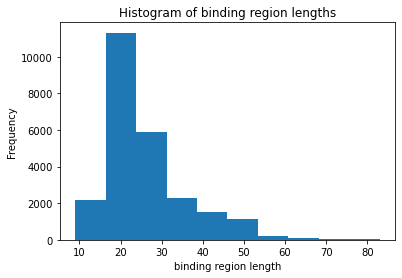

In [6]:
ax = df_main['binding_region_length'].plot(kind='hist',title='Histogram of binding region lengths')
ax.set_xlabel('binding region length')
df_main[df_main['binding_region_length'] > 70].head()

94.64 % (23389 / 24714) bs_ids have 1 exon
5.35 % (1321 / 24714) bs_ids have 2 exons
0.02 % (4 / 24714) bs_ids have 3 exons
0.0 % (0 / 24714) bs_ids have > 3 exons


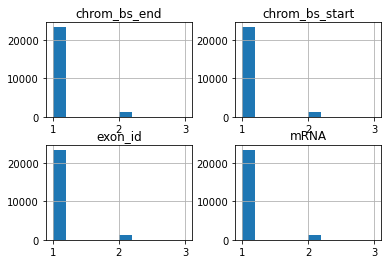

In [118]:
#visualize number bindingsites with more than 1 exon
df_exon.groupby('bs_id').count().hist()
#['exon_id'].agg('count').astype('int64').hist()
a = df_exon.groupby('bs_id').count()
print(round((len(a[a.exon_id == 1])/len(a))*100,2),'% ('+str(len(a[a.exon_id == 1]))+' / '+str(len(a))+') bs_ids have 1 exon')#23389 Zeilen
print(round((len(a[a.exon_id == 2])/len(a))*100,2),'% ('+str(len(a[a.exon_id == 2]))+' / '+str(len(a))+') bs_ids have 2 exons')#1321 Zeilen
print(round((len(a[a.exon_id == 3])/len(a))*100,2),'% ('+str(len(a[a.exon_id == 3]))+' / '+str(len(a))+') bs_ids have 3 exons')#4 Zeilen
print(round((len(a[a.exon_id > 3])/len(a))*100,2),'% ('+str(len(a[a.exon_id > 3]))+' / '+str(len(a))+') bs_ids have > 3 exons')#0 Zeilen

In [125]:
#filter out all binding sites that have more than 1 exon_id: 24714 -> 23389 bindingsites
important_counts2 = important_counts[df_exon.groupby('bs_id').count().merge(important_counts,on='bs_id').exon_id==1]
important_counts2
exon_counts
df_exon #

,mRNA,bs_id,chrom_bs_start,chrom_bs_end,exon_id
0,ENST00000600966,0,58352138,58352158,ENSE00003224625
1,ENST00000600966,1,58350645,58351407,ENSE00003509215
1,ENST00000600966,1,58350645,58351407,ENSE00003142302
2,ENST00000600966,2,58352987,58353006,ENSE00003185372
3,ENST00000600966,3,58351458,58351475,ENSE00003509215
...,...,...,...,...,...
24709,ENST00000598345,24709,58347425,58347451,ENSE00003207101
24710,ENST00000598345,24710,58347375,58347395,ENSE00003207101
24711,ENST00000598345,24711,58347505,58347518,ENSE00003207101
24712,ENST00000598345,24712,58346909,58346925,ENSE00003024001


In [ ]:
#write exoncounts to BED file for translating GRCh37 to GRCh38

file = open('chrom_pos_hg19.bed', 'w')
for row in exon_counts.iterrows():
    line = row[0]
    sep = '\t'
    strand = '+' if (row[1].strand=='1') else '-'
    start = row[1].chrom_exon_start if strand == '+' else row[1].chrom_exon_end
    end = row[1].chrom_exon_end if strand == '+' else row[1].chrom_exon_start
    string = f'chr{row[1].chromosome_name}{sep}{start}{sep}{end}{sep}{line}{sep}0{sep}{strand}\n' 
    #chr7  127471196  127472363  Pos1  0  +
    file.write(string)
file.close()
#TODO then upload to website

In [439]:
#then read in new liftover exoncounts in GRCh38 from files
df_liftover = pd.read_csv('chrom_pos_translated.bed', sep="\t",names=['chromosome_name','chrom_exon_start','chrom_exon_end','index','0','strand'])
df_liftover = df_liftover.set_index('index')
df_liftover.chromosome_name = df_liftover.apply(lambda row: row.chromosome_name[3:], axis=1)
df_liftover.strand = df_liftover.apply(lambda row: '1' if (row.strand=='+') else '-1', axis=1)
del df_liftover['0']
df_liftover.head()

,chromosome_name,chrom_exon_start,chrom_exon_end,strand
index,,,,
0,1,11874,12227,1
1,1,12595,12721,1
2,1,12613,12721,1
3,1,12646,12697,1
4,1,13221,14409,1


In [455]:
# changes of old to new df
new_exon_counts = df_liftover.join(exon_counts,rsuffix='r',lsuffix='l')#['raw_counts'])
new_exon_counts[(new_exon_counts.chrom_exon_startr != new_exon_counts.chrom_exon_startl)&(new_exon_counts.chrom_exon_startr != new_exon_counts.chrom_exon_endl)]
new_exon_counts = df_liftover.join(exon_counts['raw_counts'])
new_exon_counts.head()

,chromosome_name,chrom_exon_start,chrom_exon_end,strand,raw_counts
index,,,,,
0,1,11874,12227,1,50
1,1,12595,12721,1,0
2,1,12613,12721,1,0
3,1,12646,12697,1,0
4,1,13221,14409,1,70


## Map exons to bs

In [457]:
new_exon_counts[(exon_counts.chromosome_name == '19') & (exon_counts.strand == '-1') & (exon_counts.chrom_exon_start > 58361900) & (exon_counts.chrom_exon_start < 58362900)] #& ( exon_counts.chrom_exon_start < 58352300 )]
#exon_counts.head() #1830 #58,354,357-58,362,848

<ipython-input-457-efd565344068>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_exon_counts[(exon_counts.chromosome_name == '19') & (exon_counts.strand == '-1') & (exon_counts.chrom_exon_start > 58361900) & (exon_counts.chrom_exon_start < 58362900)] #& ( exon_counts.chrom_exon_start < 58352300 )]


,chromosome_name,chrom_exon_start,chrom_exon_end,strand,raw_counts
index,,,,,
216496,19,57848731,57850561,-1,9768


In [ ]:
df_exon[(df_exon.chromosome_name == '19') & (df_exon.strand == '-1') & (df_exon.chrom_exon_start > 58361900) & (df_exon.chrom_exon_start < 58362900)]

In [458]:
exon_info#[exon_info.ensembl_exon_id == 'ENSE00003224625'] #74 #171
#find version of exon_id to see if i can compare - TGCA
exon_info[(exon_info.chromosome_name == '19') & (exon_info.strand == '-1') & (exon_info.chrom_exon_start > 58361900) & (exon_info.chrom_exon_start < 58362900)]

,ensembl_gene_id,ensembl_transcript_id,ensembl_exon_id,chrom_exon_start,chrom_exon_end,strand,chromosome_name
59442,ENSG00000268230,ENST00000599109,ENSE00002304388,58362677,58362751,-1,19
59480,ENSG00000174586,ENST00000311044,ENSE00001376549,58362677,58362751,-1,19
59483,ENSG00000174586,ENST00000425453,ENSE00003052652,58362677,58362848,-1,19
59486,ENSG00000174586,ENST00000595763,ENSE00003176780,58362677,58362825,-1,19


In [456]:
new_exon_counts.head()

,chromosome_name,chrom_exon_start,chrom_exon_end,strand,raw_counts
index,,,,,
0,1,11874,12227,1,50
1,1,12595,12721,1,0
2,1,12613,12721,1,0
3,1,12646,12697,1,0
4,1,13221,14409,1,70


In [ ]:
#merge bs with exon counts, real slow, TODO cython, 22.34 - lookup when

def is_in_exon(row, exon_counts, df_exon_all,exon_info):
    bs_start = row.chrom_bs_start
    bs_end = row.chrom_bs_end
    df_exon = df_exon_all[df_exon_all.bs_id == row.bs_id]
    df_exon = df_exon.merge(exon_info, left_on='exon_id', right_on='ensembl_exon_id') #this works only for 1 exon per bs
    here = exon_counts.loc[(exon_counts['chromosome_name'] == df_exon.chromosome_name.values[0]) & (exon_counts['strand'] == df_exon.strand.values[0]) & (exon_counts['chrom_exon_start'] == df_exon.chrom_exon_start.values[0]) & (exon_counts['chrom_exon_end'] == df_exon.chrom_exon_end.values[0])]
    #print(here)
    count_list = str(list(here['raw_counts']))[1:-1]
    return count_list if not count_list == '' else None

#takes long! for 1 case id: 2 min 
#exon_counts = all_exon_dfs['aba26e6b-f11c-4ae6-a0d6-85bdd2060e8f'] #df#all_exon_dfs[case_id]
important_counts['exon'] = important_counts.apply(lambda row: is_in_exon(row,new_exon_counts,df_exon,exon_info), axis=1)
bs_exons = pd.DataFrame(important_counts.exons.str.split(',').tolist(),index=important_counts.bs_id)
bs_exons = bs_exons.rename(columns={0: "exon_raw_count"})
bs_exons.head()
#TODO takes fuuuuuckin long, instead join on strand, chromosome_name, start, end

In [ ]:
%%cython
def is_in_exon(row, exon_counts):
    bs_start = row.chrom_bs_start
    bs_end = row.chrom_bs_end
    here = exon_counts.loc[(exon_counts['chromosome_name'] == row.chromosome_name) & (exon_counts['strand'] == row.strand) & (exon_counts['chrom_exon_start'] <= bs_start) & (exon_counts['chrom_exon_end'] >= bs_end)]
    count_list = str(list(here['raw_counts']))[1:-1]
    return count_list if not count_list == '' else None
#merge bs (important_counts) with exon counts (new_exon_counts)
#takes too long! for 1 case id: x min 
important_counts['exon'] = important_counts.apply(lambda row: is_in_exon(row,new_exon_counts), axis=1)
bs_exons = pd.DataFrame(important_counts.exons.str.split(',').tolist(),index=important_counts.bs_id)
bs_exons = bs_exons.rename(columns={0: "exon_raw_count"})
bs_exons.head()

In [101]:
important_counts
exon_counts
#df_exon #TODO add id version? (biomart)
#first match transcript for far smaller searchspace, then match positions of exon
#get ['exon_id'] = 
#important_counts: bs_id, transcript_id, exon_id, mirna    TODO if > 1 exon: remove row
#exon_id count      from exon_counts (or also counts in important counts) 
#exon id (mature) mirna_id family count

,raw_counts,median_length_normalized,RPKM,chromosome_name,strand,chrom_exon_start,chrom_exon_end
0,61,0.9036827,1.21214019174369,1,1,11874,12227
1,16,0.8333333,0.886222027370111,1,1,12595,12721
2,15,0.8055556,0.96803495535554,1,1,12613,12721
3,12,0.8823529,1.62332015590391,1,1,12646,12697
4,287,0.9166667,1.69795556537075,1,1,13221,14409
...,...,...,...,...,...,...,...
239317,499,1.0000000,113.230944638157,M_rCRS,1,12207,12237
239318,49206,1.0000000,149.971431353018,M_rCRS,1,12337,14644
239319,181297,1.0000000,1131.6001082413,M_rCRS,1,14761,15887
239320,1587,1.0000000,60.3436362818982,M_rCRS,1,15998,16182


## Map miRNA to bs

In [94]:
#map miRNA ID to mature ID
mirna_counts = all_mirna_dfs['45bdcfd6-1e3f-4be8-b843-ae949e8e43eb']#case_id]

trans = pd.DataFrame.from_dict(read_in_miRNA(path2+'miRNA2mature.fasta'), orient='index')#,columns=["mirna", "mature"])
trans = trans.rename(columns={0: "miRNA_ID"})
trans[['miRNA_ID']] = trans[['miRNA_ID']].astype('str').astype('category')
print(trans)

#map miRNA to miRNA family
mirna_families = read_in_mirna_families(path_tarp+'mapping_miRNA_families.fasta')
trans = trans.join(mirna_families,how='inner')

bs_mirnas = important_counts[['exon_id','miRNA']].join(trans,on='miRNA').merge(mirna_counts[['miRNA_ID','read_count']],on='miRNA_ID')
#print(bs_mirnas)
bs_mirnas.drop(['miRNA','miRNA_ID'], axis=1, inplace=True)
bs_mirnas = bs_mirnas.rename(columns={'read_count': "mirna_read_count"})
bs_mirnas.head()

                           miRNA_ID
cel-let-7-5p              cel-let-7
cel-let-7-3p              cel-let-7
cel-lin-4-5p              cel-lin-4
cel-lin-4-3p              cel-lin-4
cel-miR-1-3p              cel-mir-1
...                             ...
gga-miR-1784b-5p      gga-mir-1784b
gga-miR-1784b-3p      gga-mir-1784b
mdo-miR-7385g-3p    mdo-mir-7385g-1
mdo-miR-7385g-2-3p  mdo-mir-7385g-2
NA                      vvi-MIR828b

[49156 rows x 1 columns]


KeyError: "['exon_id'] not in index"

In [79]:
trans 
important_counts
mirna_counts
exon_counts
#2693 with hsa in miRNA2mature / 49156 overall in miRNA2mature (also other species eg cel)
#2656 if inner join cause only 2656 families
#TODO check if miRNA counts from TCGA are more different miRNAs?
#TODO is inner right? are some in important counts None?

,exon,raw_counts,median_length_normalized,RPKM
0,chr1:11874-12227:+,61,0.9036827,1.21214019174369
1,chr1:12595-12721:+,16,0.8333333,0.886222027370111
2,chr1:12613-12721:+,15,0.8055556,0.96803495535554
3,chr1:12646-12697:+,12,0.8823529,1.62332015590391
4,chr1:13221-14409:+,287,0.9166667,1.69795556537075
...,...,...,...,...
239317,chrM_rCRS:12207-12237:+,499,1.0000000,113.230944638157
239318,chrM_rCRS:12337-14644:+,49206,1.0000000,149.971431353018
239319,chrM_rCRS:14761-15887:+,181297,1.0000000,1131.6001082413
239320,chrM_rCRS:15998-16182:+,1587,1.0000000,60.3436362818982


In [20]:
#output: for each case_id for each bs_id: interesting miRNA expression + exon expression
#then regression btw miRNA expression, exon expression
both = bs_exons.merge(bs_mirnas, on='bs_id', how='outer').merge(df_exon, on='bs_id')
if both.exon_raw_count.count() < len(both):
    print('Error: Number of exon count rows with None:',len(both) - both.exon_raw_count.count(),'/',len(both))
    #this is because we dont have all the bs predictions yet?
if both.mirna_read_count.count() < len(both):
    print('Error: Number of mirna count rows with None:',both[pd.isnull(both['mirna_read_count']) & pd.isnull(both['exon_raw_count'])])
    #this is because for this case we dont information on this mirna in TGCA?
both = both.dropna()
both[['exon_raw_count','mirna_read_count']] = both[['exon_raw_count','mirna_read_count']].astype('int')
both.head()

both_sum = both.drop_duplicates(subset='exon_id')[['exon_raw_count','exon_id']].merge(both.groupby(['exon_id'])['mirna_read_count'].agg('sum'),on='exon_id')
both_sum[['exon_raw_count','mirna_read_count']] = both_sum[['exon_raw_count','mirna_read_count']].astype('int')
both_sum = both_sum.rename(columns={'mirna_read_count': 'mirna_read_count_sum'})
both_sum.head()
#both.head()
#TODO check - is nr mirna downloaded also here? if not: mistake
#TODo step both is unnecessary, remove and directly merge 2 df as in slides (in case summing up is right)

NameError: name 'bs_exons' is not defined

## Elastic Net Regression

In [147]:
import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
#faster if np.array(x, order='F')
#If you are interested in controlling the L1 and L2 penalty separately, keep in mind that this is equivalent to:
#a * L1 + b * L2 where: alpha = a + b and l1_ratio = a / (a + b)
X, y = both_sum.mirna_read_count, both_sum.exon_raw_count
regr = ElasticNet(random_state=0)
regr.fit(X, y)
print(regr.coef_)

#X{ndarray, sparse matrix} of (n_samples, n_features) data
#y{ndarray, sparse matrix} of shape (n_samples,) or (n_samples, n_targets) target, auto cast to x

#print(regr.intercept_)
#print(regr.predict([[0, 0]]))

ValueError: Expected 2D array, got 1D array instead:
array=[1320. 1490.  300.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [20]:
#improve memory of DataFrame
#converting object variable of type string to categorical -> reduce memory
print(important_counts.info(memory_usage='deep'))
a = important_counts.select_dtypes(include=['object']).copy()
a.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   bs_id            5 non-null      int64   
 1   miRNA            5 non-null      category
 2   mRNA             5 non-null      category
 3   chrom_bs_start   5 non-null      int64   
 4   chrom_bs_end     5 non-null      int64   
 5   chromosome_name  5 non-null      category
 6   strand           5 non-null      category
 7   exons            5 non-null      object  
dtypes: category(4), int64(3), object(1)
memory usage: 250.0 KB
None


,exons
count,5
unique,1
top,
freq,5
